## This notebook illustrates every step of the process of training models for ic labeling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

First of all, we need the dataset. We can download and it using the following commands.

In [ ]:
!curl -O http://168.119.186.83/media/downloads/dataset_Kids_v0.1.zip
!unzip dataset_Kids_v0.1.zip

Now, we load the dataset. For this we use the special function, which reads the csv-files from the directory and puts the data in a convenient format.

In [2]:
from data import load_dataset

dir = 'dataset_Kids'

data, raw_annotations = load_dataset(dir)

Now, we calculate features for each ic in the dataset.

In [3]:
from features import build_feature_df

features = build_feature_df(data, default=True, custom_features={})
features

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,AMALB
IC000262,1.072924,7.849818,1.218625,0.312472,0.034570,0.048681,0.019231,0.008782,0.532586,-0.436746,1.011637
IC000263,-0.258669,2.826228,-0.098488,-0.017333,0.198680,0.194712,0.000708,0.000991,0.117395,0.040816,2.849186
IC000264,-0.281039,2.405500,0.048190,-0.005600,0.195810,0.135989,0.000826,0.001222,0.156479,-0.006563,3.377169
IC000265,-0.109386,2.304496,-0.153483,-0.047035,0.102357,0.137081,0.001293,0.000845,-0.015456,0.105652,3.772572
IC000266,-0.184636,2.180311,-0.098674,-0.010143,0.185123,0.238028,0.000109,0.000302,-0.036227,0.126880,3.964019
...,...,...,...,...,...,...,...,...,...,...,...
IC000877,-0.146957,6.988684,0.042727,-0.004911,0.025780,0.121094,0.000665,0.001510,0.065716,0.016142,3.993653
IC000878,-0.239456,3.270491,-0.024471,-0.000694,0.116370,0.088207,0.001756,0.001765,-0.005558,0.079040,4.264880
IC000879,-0.205477,4.605998,0.052680,0.000121,0.037387,0.114119,0.000769,0.000845,0.049253,-0.022909,4.072748
IC000880,-0.177250,3.021220,-0.042368,-0.000086,0.097905,0.117893,0.000812,0.001312,-0.050189,0.038057,4.659919


Targets are calculated as the average of the answers of multiple experts for each ic.

In [4]:
def get_target_distribution(annotations):
    return annotations.groupby('ic_id').mean().apply(lambda x: x.value_counts())

get_target_distribution(raw_annotations)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_muscles,flag_heart,flag_line_noise,flag_ch_noise
0.000000,94.0,546.0,523.0,243.0,536.0,564.0,306.0,369.0,608.0,380.0
0.142857,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
0.200000,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,NaN,NaN
0.250000,NaN,4.0,1.0,3.0,5.0,3.0,NaN,5.0,NaN,NaN
0.333333,9.0,10.0,4.0,17.0,3.0,2.0,17.0,12.0,2.0,4.0
0.400000,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
0.500000,115.0,52.0,77.0,311.0,63.0,39.0,170.0,222.0,10.0,193.0
0.600000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0.666667,18.0,NaN,NaN,2.0,1.0,NaN,11.0,1.0,NaN,4.0
0.750000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For now we do not want to distinguish between eye movement types, so we unite them under `'flag_eyes'`. We also presume the positive label for `'flag_alpha'` or `'flag_mu'` implies the positive label for `'flag_brain'`. Finally, since we do not have sufficient data for distinguishing line noise, we will not consider this flag.

In [5]:
def propogate_labels(annotations):
    return annotations.assign(flag_eyes=annotations[['flag_eyes', 'flag_eyes_h', 'flag_eyes_v']].any(axis=1),
                              flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1)) \
                      .drop(columns=['flag_eyes_v', 'flag_eyes_h', 'flag_line_noise'])

annotations = propogate_labels(raw_annotations)
get_target_distribution(annotations)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
0.000000,93.0,546.0,523.0,223.0,306.0,369.0,380.0
0.142857,NaN,NaN,NaN,NaN,1.0,1.0,NaN
0.200000,NaN,NaN,NaN,1.0,NaN,2.0,NaN
0.250000,NaN,4.0,1.0,6.0,NaN,5.0,NaN
0.333333,9.0,10.0,4.0,17.0,17.0,12.0,4.0
0.400000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0.500000,103.0,52.0,77.0,307.0,170.0,222.0,193.0
0.666667,12.0,NaN,NaN,2.0,11.0,1.0,4.0
0.750000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0.800000,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In order to get binary labels we apply threshold to these averages. Threshold values are chosen for each flag.

In [6]:
from data import build_target_df

targets = build_target_df(annotations, strategy='mean', threshold=[1, .5, .5, .5, 1, .5, .5])
targets = targets.loc[:, targets.any(axis=0) & ~targets.all(axis=0)]
targets

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
ic_id,,,,,,,
IC000262,False,False,False,True,False,False,False
IC000263,True,False,False,True,False,False,True
IC000264,True,False,False,True,False,True,True
IC000265,True,False,False,True,False,False,True
IC000266,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...
IC000877,True,False,False,False,False,True,False
IC000878,True,False,False,False,False,True,False
IC000879,True,False,False,False,False,True,False


For training we use XGboost, LinearSVM, and Logistic Regression with default parameters. We do a stratified train-test split with test size = 0.3.

In [12]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = {'LR': LogisticRegression(solver='liblinear', penalty='l2', C=1.0),
          'XGB': XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=30, eval_metric='logloss'),
          'SVM': SVC(kernel='linear', probability=True)}
n_repeats = 50

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, RocCurveDisplay

def plot_roc_curve(ax, y_true, y_pred, title=None, lw=2, color='darkorange', **kwargs):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    ax.set_title(title)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax, color=color, lw=lw, **kwargs)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

In [18]:
def repeated_train_test(features, target, model, n_repeats, test_size=0.3, ax=None, random_state=57):
    roc_aucs = []
    f1_scores = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_aucs.append(roc_auc_score(y_test, y_proba))
        f1_scores.append(f1_score(y_test, y_pred))
        if ax is not None:
            plot_roc_curve(ax, y_test, y_proba, alpha=.1)

    if ax is not None:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(flag)
        ax.set_ylabel('')
        ax.legend([f'average AUC = {np.mean(roc_aucs):.4f}',
                   f'average F1 = {np.mean(f1_scores):.4f}'])
    return roc_aucs, f1_scores

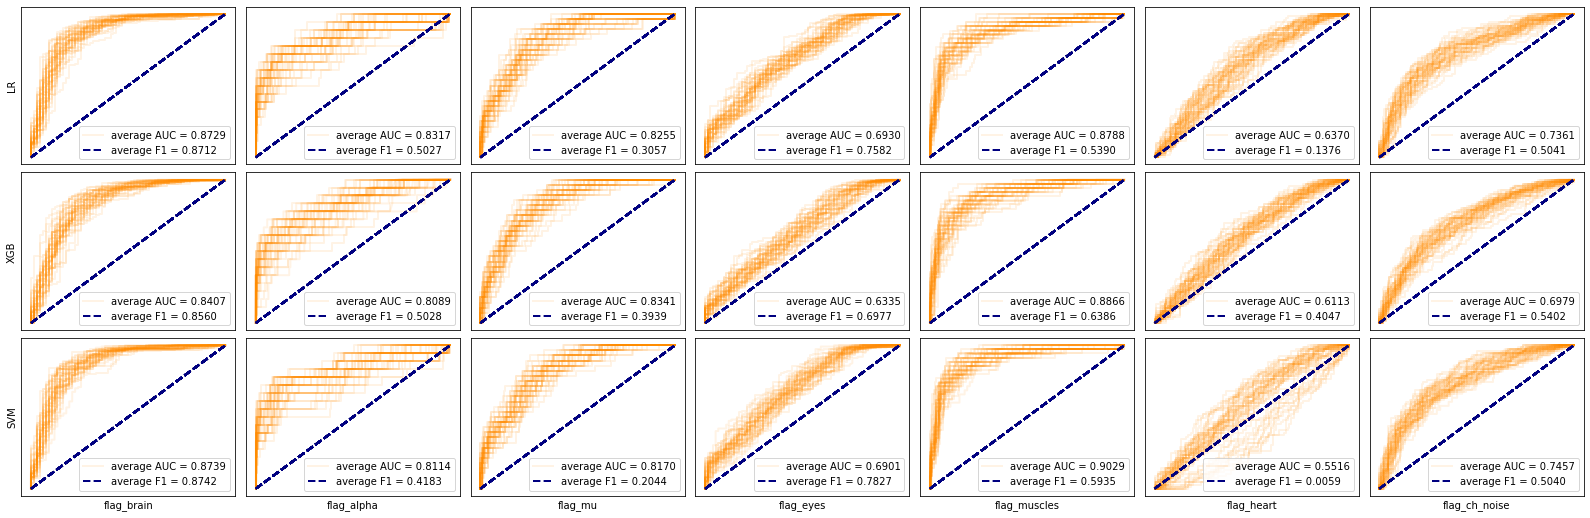

In [19]:
fig, axes = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

for (model_name, model), row in zip(models.items(), axes):
    for flag, ax in zip(targets, row):
        repeated_train_test(features, targets[flag], model, n_repeats, ax=ax)
        ax.set_xlabel('')
    row[0].set_ylabel(model_name)
for target_name, ax in zip(targets, axes[-1]):
    ax.set_xlabel(target_name)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [20]:
from itertools import product

roc_aucs = pd.DataFrame(index=models, columns=targets.columns, dtype=float)
f1_scores = pd.DataFrame(index=models, columns=targets.columns, dtype=float)

for (model_name, model), flag in product(models.items(), targets):
        auc_values, f1_values = repeated_train_test(features, targets[flag], model, n_repeats)
        roc_aucs.loc[model_name, flag] = np.mean(auc_values)
        f1_scores.loc[model_name, flag] = np.mean(f1_values)

In [21]:
roc_aucs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.872884,0.831667,0.825502,0.692983,0.878821,0.637025,0.736130
XGB,0.840703,0.808872,0.834073,0.633541,0.886562,0.611318,0.697927
SVM,0.873891,0.811425,0.817021,0.690132,0.902860,0.551594,0.745668


In [22]:
f1_scores

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.871225,0.502659,0.305703,0.758177,0.538963,0.137648,0.504142
XGB,0.855972,0.502797,0.393931,0.697685,0.638633,0.404676,0.540187
SVM,0.874193,0.418350,0.204363,0.782702,0.593549,0.005934,0.504021


For each flag we choose the model with the best average of ROC-AUC and F1 scores.

In [23]:
models_to_use = (f1_scores + roc_aucs).idxmax()

Finally, we train each model on the entire data and save them all to a pickle-file.

In [24]:
import pickle
from copy import deepcopy

trained_models = {}

for flag_name, model_name in models_to_use.items():
    model = deepcopy(models[model_name])
    trained_models[flag_name] = model.fit(features, targets[flag_name])

with open('trained_models/models.pickle', 'wb') as output:
    pickle.dump(trained_models, output)